In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load Raw Data

In [2]:
# Step 2: Load Raw Data
df = pd.read_csv("raw_data.csv")
df.head()

,DateTime,Junction,Vehicles,ID,Temperature,Precipitation,Humidity,WindSpeed,Date,Event_Type,Event_Name,Event_Flag
0,2015-11-01 00:00:00,1,15,20151101001,23.2,0.0,67,11.4,2015-11-01,No Event,No Event,0
1,2015-11-01 01:00:00,1,13,20151101011,22.6,0.0,70,10.7,2015-11-01,No Event,No Event,0
2,2015-11-01 02:00:00,1,10,20151101021,22.0,0.0,73,10.0,2015-11-01,No Event,No Event,0
3,2015-11-01 03:00:00,1,7,20151101031,21.5,0.0,75,8.2,2015-11-01,No Event,No Event,0
4,2015-11-01 04:00:00,1,9,20151101041,21.0,0.0,77,8.4,2015-11-01,No Event,No Event,0


In [3]:
# check shape of data
df.shape

(48120, 12)

In [4]:
# 48120 rows and 12 columns

In [5]:
# print columns name
df.columns

Index(['DateTime', 'Junction', 'Vehicles', 'ID', 'Temperature',
       'Precipitation', 'Humidity', 'WindSpeed', 'Date', 'Event_Type',
       'Event_Name', 'Event_Flag'],
      dtype='str')

In [6]:
# 1) DateTime
# Date and time of traffic record
# Used to extract hour, day, month
# Important for time-series forecasting

# 2) Junction
# ID of road junction/intersection
# Helps analyze traffic per location

# 3) Vehicles
# Number of vehicles recorded
# Target variable (what we predict)

# 4) ID
# Unique row identifier
# Not useful for prediction
# Can be removed

# ️5) Temperature
# Temperature at that time (°C)
# May influence traffic flow

# ️6) Precipitation
# Rainfall amount
# Heavy rain may increase congestion

# ️7) Humidity
# Air moisture percentage
# Minor effect on traffic

# ️8) WindSpeed
# Wind speed at that time
# Usually small impact

# ️9) Date
# Date without time
# Can be removed if DateTime is used

# 10) Event_Type
# Type of event (Festival, Holiday, etc.)
# Events increase traffic

# 11) Event_Name
# Specific event name
# Can be encoded if needed

# 12) Event_Flag
# Binary indicator (1 = event, 0 = no event)


In [7]:
# check information of data
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DateTime       48120 non-null  str    
 1   Junction       48120 non-null  int64  
 2   Vehicles       48120 non-null  int64  
 3   ID             48120 non-null  int64  
 4   Temperature    48120 non-null  float64
 5   Precipitation  48120 non-null  float64
 6   Humidity       48120 non-null  int64  
 7   WindSpeed      48120 non-null  float64
 8   Date           48120 non-null  str    
 9   Event_Type     48120 non-null  str    
 10  Event_Name     48120 non-null  str    
 11  Event_Flag     48120 non-null  int64  
dtypes: float64(3), int64(5), str(4)
memory usage: 6.5 MB


In [8]:
# observation:-
# from above it is observe that DateTime column datatype is str it is not datetime

# Clean Data:

In [9]:
# Step 3: Convert Datetime column datatype into DateTime
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [10]:
print(df['DateTime'].dtype)

datetime64[us]


In [11]:
# Step 4: Check Missing Values
df.isnull().sum()

DateTime         0
Junction         0
Vehicles         0
ID               0
Temperature      0
Precipitation    0
Humidity         0
WindSpeed        0
Date             0
Event_Type       0
Event_Name       0
Event_Flag       0
dtype: int64

In [12]:
# observation:-
# there is no any null value present in dataset

In [13]:
# Step 5: Handle Missing Values - if any missing value present then it will handle
# Fill numerical columns with mean
num_cols = ['Vehicles', 'Temperature', 'Precipitation',
            'Humidity', 'WindSpeed']

for col in num_cols:
    df[col] = df[col].fillna(df[col].mean())

# Fill categorical columns with mode (if any missing)
cat_cols = ['Event_Type', 'Event_Name']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing Values After Handling:\n", df.isnull().sum())


Missing Values After Handling:
 DateTime         0
Junction         0
Vehicles         0
ID               0
Temperature      0
Precipitation    0
Humidity         0
WindSpeed        0
Date             0
Event_Type       0
Event_Name       0
Event_Flag       0
dtype: int64


In [14]:
df.shape

(48120, 12)

In [15]:
# Step 6: check duplicate values
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
48115    False
48116    False
48117    False
48118    False
48119    False
Length: 48120, dtype: bool

In [16]:
# Remove Duplicates if any present
df = df.drop_duplicates()

In [17]:
print("Shape After Removing Duplicates:", df.shape)

Shape After Removing Duplicates: (48120, 12)


In [18]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       48120 non-null  datetime64[us]
 1   Junction       48120 non-null  int64         
 2   Vehicles       48120 non-null  int64         
 3   ID             48120 non-null  int64         
 4   Temperature    48120 non-null  float64       
 5   Precipitation  48120 non-null  float64       
 6   Humidity       48120 non-null  int64         
 7   WindSpeed      48120 non-null  float64       
 8   Date           48120 non-null  str           
 9   Event_Type     48120 non-null  str           
 10  Event_Name     48120 non-null  str           
 11  Event_Flag     48120 non-null  int64         
dtypes: datetime64[us](1), float64(3), int64(5), str(3)
memory usage: 5.6 MB


# Aggregate Traffic Data Hourly

In [19]:
# Forecast hourly traffic volume at different junctions. But raw data may be:
# Minute-wise
# Multiple records per hour
# Irregular timestamps

# Machine learning models need:Clean, Structured, Consistent hourly intervals
# We aggregate because:
# To Convert Raw Data → Hourly Traffic
# If 20 vehicle entries exist in one hour, we combine them.

In [20]:
df['DateTime'] = pd.to_datetime(df['DateTime'])  # ensure datetime
df = df.set_index('DateTime')                    # set as index

In [21]:
df.index

DatetimeIndex(['2015-11-01 00:00:00', '2015-11-01 01:00:00',
               '2015-11-01 02:00:00', '2015-11-01 03:00:00',
               '2015-11-01 04:00:00', '2015-11-01 05:00:00',
               '2015-11-01 06:00:00', '2015-11-01 07:00:00',
               '2015-11-01 08:00:00', '2015-11-01 09:00:00',
               ...
               '2017-06-30 14:00:00', '2017-06-30 15:00:00',
               '2017-06-30 16:00:00', '2017-06-30 17:00:00',
               '2017-06-30 18:00:00', '2017-06-30 19:00:00',
               '2017-06-30 20:00:00', '2017-06-30 21:00:00',
               '2017-06-30 22:00:00', '2017-06-30 23:00:00'],
              dtype='datetime64[us]', name='DateTime', length=48120, freq=None)

In [22]:
df.head()

,Junction,Vehicles,ID,Temperature,Precipitation,Humidity,WindSpeed,Date,Event_Type,Event_Name,Event_Flag
DateTime,,,,,,,,,,,
2015-11-01 00:00:00,1,15,20151101001,23.2,0.0,67,11.4,2015-11-01,No Event,No Event,0
2015-11-01 01:00:00,1,13,20151101011,22.6,0.0,70,10.7,2015-11-01,No Event,No Event,0
2015-11-01 02:00:00,1,10,20151101021,22.0,0.0,73,10.0,2015-11-01,No Event,No Event,0
2015-11-01 03:00:00,1,7,20151101031,21.5,0.0,75,8.2,2015-11-01,No Event,No Event,0
2015-11-01 04:00:00,1,9,20151101041,21.0,0.0,77,8.4,2015-11-01,No Event,No Event,0


In [23]:
# Aggregate hourly per junction
df_hourly = df.groupby('Junction').resample('h').agg({
    'Vehicles': 'sum',          # Total vehicles per hour
    'Temperature': 'mean',      # Average temperature
    'Precipitation': 'mean',    # Average precipitation
    'Humidity': 'mean',         # Average humidity
    'WindSpeed': 'mean',        # Average wind speed
    'Event_Flag': 'max'         # If any event occurred in that hour
}).reset_index()

In [24]:
print("Hourly Aggregated Data Shape:", df_hourly.shape)

Hourly Aggregated Data Shape: (48120, 8)


In [25]:
print(df_hourly.head())

   Junction            DateTime  Vehicles  Temperature  Precipitation  \
0         1 2015-11-01 00:00:00        15         23.2            0.0   
1         1 2015-11-01 01:00:00        13         22.6            0.0   
2         1 2015-11-01 02:00:00        10         22.0            0.0   
3         1 2015-11-01 03:00:00         7         21.5            0.0   
4         1 2015-11-01 04:00:00         9         21.0            0.0   

   Humidity  WindSpeed  Event_Flag  
0      67.0       11.4           0  
1      70.0       10.7           0  
2      73.0       10.0           0  
3      75.0        8.2           0  
4      77.0        8.4           0  


In [26]:

# Feature Engineering 

df_hourly['Hour'] = df_hourly['DateTime'].dt.hour
df_hourly['Day'] = df_hourly['DateTime'].dt.day
df_hourly['Month'] = df_hourly['DateTime'].dt.month
df_hourly['DayOfWeek'] = df_hourly['DateTime'].dt.dayofweek
df_hourly['IsWeekend'] = df_hourly['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

In [27]:
# STEP 6: Standardization

scaler = StandardScaler()

scale_cols = ['Temperature', 'Precipitation',
              'Humidity', 'WindSpeed']

df_hourly[scale_cols] = scaler.fit_transform(df_hourly[scale_cols])

print("\nFinal Processed Data:")
print(df_hourly.head())


Final Processed Data:
   Junction            DateTime  Vehicles  Temperature  Precipitation  \
0         1 2015-11-01 00:00:00        15    -0.487137      -0.149178   
1         1 2015-11-01 01:00:00        13    -0.596649      -0.149178   
2         1 2015-11-01 02:00:00        10    -0.706161      -0.149178   
3         1 2015-11-01 03:00:00         7    -0.797422      -0.149178   
4         1 2015-11-01 04:00:00         9    -0.888682      -0.149178   

   Humidity  WindSpeed  Event_Flag  Hour  Day  Month  DayOfWeek  IsWeekend  
0  0.631414  -0.197765           0     0    1     11          6          1  
1  0.752838  -0.318525           0     1    1     11          6          1  
2  0.874261  -0.439286           0     2    1     11          6          1  
3  0.955210  -0.749814           0     3    1     11          6          1  
4  1.036159  -0.715311           0     4    1     11          6          1  


In [28]:
# FINAL DATA INFO
print("\nFinal Dataset Info:")
print(df_hourly.info())


Final Dataset Info:
<class 'pandas.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Junction       48120 non-null  int64         
 1   DateTime       48120 non-null  datetime64[us]
 2   Vehicles       48120 non-null  int64         
 3   Temperature    48120 non-null  float64       
 4   Precipitation  48120 non-null  float64       
 5   Humidity       48120 non-null  float64       
 6   WindSpeed      48120 non-null  float64       
 7   Event_Flag     48120 non-null  int64         
 8   Hour           48120 non-null  int32         
 9   Day            48120 non-null  int32         
 10  Month          48120 non-null  int32         
 11  DayOfWeek      48120 non-null  int32         
 12  IsWeekend      48120 non-null  int64         
dtypes: datetime64[us](1), float64(4), int32(4), int64(4)
memory usage: 4.0 MB
None


# Peak Hour Identification & Pattern Analysis

In [29]:
# step:7 Calculate Hourly Congestion Metrics
# Average vehicle count per hour (0–23)
hourly_avg = df_hourly.groupby('Hour')['Vehicles'].mean().reset_index()
print(hourly_avg)
# Groups all data by hour (0–23)
# Calculates average vehicle count per hour

    Hour   Vehicles
0      0  23.540648
1      1  19.654863
2      2  17.102743
3      3  14.847382
4      4  12.973067
5      5  12.173566
6      6  12.980050
7      7  14.703242
8      8  16.402993
9      9  19.379551
10    10  24.229925
11    11  27.495262
12    12  28.403990
13    13  25.588529
14    14  27.702743
15    15  27.650374
16    16  26.674314
17    17  26.648379
18    18  28.095262
19    19  29.854863
20    20  29.824938
21    21  28.202993
22    22  27.226933
23    23  25.635411


In [30]:
# # Observation:
# 1) Lowest Traffic:
# Minimum traffic at 5 AM (12.17 vehicles).
# Early morning (4 AM – 6 AM) is off-peak period.

# ️2) Morning Increase:
# Traffic starts increasing after 6 AM.
# Gradual rise from 7 AM onwards.

# ️3) Midday Traffic:
# High traffic between 11 AM – 3 PM.
# Around 12 PM (~28 vehicles) shows strong daytime activity.

# ️4) Peak Hours (Highest Congestion):
# Maximum at 7 PM (29.85 vehicles).
# Peak period: 6 PM – 8 PM.

# ️5) Night Trend:
# Traffic decreases after 9 PM, but remains moderate until midnight.

In [31]:
# Step:8 Identify Peak Hours Using Mean & Standard Deviation
hourly_stats = df_hourly.groupby('Hour')['Vehicles'].agg(['mean','std']).reset_index()
print(hourly_stats)


    Hour       mean        std
0      0  23.540648  19.148046
1      1  19.654863  16.310962
2      2  17.102743  14.159042
3      3  14.847382  12.333346
4      4  12.973067  10.668348
5      5  12.173566   9.982610
6      6  12.980050  11.037344
7      7  14.703242  12.482891
8      8  16.402993  13.767212
9      9  19.379551  16.201207
10    10  24.229925  20.842904
11    11  27.495262  24.142347
12    12  28.403990  24.568723
13    13  25.588529  21.684610
14    14  27.702743  23.902777
15    15  27.650374  23.402236
16    16  26.674314  22.204169
17    17  26.648379  22.089605
18    18  28.095262  24.159760
19    19  29.854863  25.532148
20    20  29.824938  25.446723
21    21  28.202993  23.654558
22    22  27.226933  22.178798
23    23  25.635411  20.715091


In [32]:
# Observation:
# Mean - average congestion
# Std - variability (how unstable traffic is)
# Evening (6 PM – 8 PM) has the most traffic and traffic changes a lot during this time.
# Early morning (4 AM – 6 AM) has the least traffic and traffic stays almost the same (very stable).
# High standard deviation during peak hours suggests traffic congestion is inconsistent and may depend on external factors such as weather or events.

In [33]:
# Step 9: Moving Average
hourly_avg['Moving_Avg'] = hourly_avg['Vehicles'].rolling(window=3).mean()
print(hourly_avg)


    Hour   Vehicles  Moving_Avg
0      0  23.540648         NaN
1      1  19.654863         NaN
2      2  17.102743   20.099418
3      3  14.847382   17.201663
4      4  12.973067   14.974397
5      5  12.173566   13.331338
6      6  12.980050   12.708894
7      7  14.703242   13.285619
8      8  16.402993   14.695428
9      9  19.379551   16.828595
10    10  24.229925   20.004156
11    11  27.495262   23.701579
12    12  28.403990   26.709726
13    13  25.588529   27.162594
14    14  27.702743   27.231754
15    15  27.650374   26.980549
16    16  26.674314   27.342477
17    17  26.648379   26.991022
18    18  28.095262   27.139318
19    19  29.854863   28.199501
20    20  29.824938   29.258354
21    21  28.202993   29.294264
22    22  27.226933   28.418288
23    23  25.635411   27.021779


In [34]:
# Observations:-
# Early morning (4 AM – 6 AM) = least traffic
# Evening (6 PM – 8 PM) = highest traffic
# Traffic follows a clear daily pattern:
# Low in early morning
# Medium in daytime
# Highest in evening
# Slowly decreases at night

In [35]:
# Step 10: Weekday vs Weekend Hourly Peak Comparison
# Weekday hourly average
weekday_hourly = df_hourly[df_hourly['IsWeekend'] == 0] \
                    .groupby('Hour')['Vehicles'].mean().reset_index()

# Weekend hourly average
weekend_hourly = df_hourly[df_hourly['IsWeekend'] == 1] \
                    .groupby('Hour')['Vehicles'].mean().reset_index()

print("Weekday Peak Hour:")
print(weekday_hourly.loc[weekday_hourly['Vehicles'].idxmax()])

print("Weekend Peak Hour:")
print(weekend_hourly.loc[weekend_hourly['Vehicles'].idxmax()])

Weekday Peak Hour:
Hour        19.000000
Vehicles    32.389547
Name: 19, dtype: float64
Weekend Peak Hour:
Hour        20.000000
Vehicles    25.689474
Name: 20, dtype: float64


In [36]:
# # Observations:-
# On weekdays, the highest traffic is at 7 PM (19:00) with about 32 vehicles.
# On weekends, the highest traffic is at 8 PM (20:00) with about 26 vehicles.

# Traffic is heavier on weekdays because of office and work travel.
# On weekends, traffic is lower and slightly later in the evening.

In [37]:
# Step 11: Day of Week Analysis
daywise = df_hourly.groupby('DayOfWeek')['Vehicles'].mean().reset_index()
print(daywise)

   DayOfWeek   Vehicles
0          0  24.409408
1          1  25.286731
2          2  25.149681
3          3  25.152875
4          4  23.802120
5          5  18.544611
6          6  17.134727


In [38]:
# Observations:-
# Traffic is high from Monday to Friday (especially mid-week).
# Traffic drops significantly on weekends.
# Sunday has the least congestion.

In [39]:
# Step 12: Monthly Pattern
monthly_pattern = df_hourly.groupby('Month')['Vehicles'].mean().reset_index()
print(monthly_pattern)


    Month   Vehicles
0       1  19.727343
1       2  22.962312
2       3  23.073349
3       4  24.454365
4       5  24.633449
5       6  26.032143
6       7  21.837814
7       8  21.936380
8       9  25.644907
9      10  26.551075
10     11  19.534259
11     12  18.963934


In [40]:
# Observations:-
# ️ Traffic is highest in June and October
#  Likely due to increased travel, business activity, or festive season.

# ️ Traffic is moderate during Feb–May and September
#  These are regular working months with steady daily movement.

# ️ Traffic is lower in July–August and November–December
#  Possibly due to monsoon season and winter holidays reducing travel.

#  January has relatively low traffic
#  Possibly due to New Year holidays and fewer working days at the start of the year.

In [41]:
# Step 13: Correlation with Weather & Events
correlation = df_hourly[['Vehicles','Temperature',
                         'Precipitation','Humidity',
                         'WindSpeed','Event_Flag']].corr()

print(correlation)

               Vehicles  Temperature  Precipitation  Humidity  WindSpeed  \
Vehicles       1.000000     0.170478       0.020559 -0.109067   0.069148   
Temperature    0.170478     1.000000      -0.043752 -0.639492   0.207042   
Precipitation  0.020559    -0.043752       1.000000  0.199112   0.086322   
Humidity      -0.109067    -0.639492       0.199112  1.000000   0.113374   
WindSpeed      0.069148     0.207042       0.086322  0.113374   1.000000   
Event_Flag    -0.008639    -0.001357      -0.009859  0.001986   0.004927   

               Event_Flag  
Vehicles        -0.008639  
Temperature     -0.001357  
Precipitation   -0.009859  
Humidity         0.001986  
WindSpeed        0.004927  
Event_Flag       1.000000  


In [42]:
# # Observations:-
# Temperature (0.17) - Slight positive relation
# When temperature increases, traffic slightly increases. (But effect is weak.)

# Humidity (-0.10) - Slight negative relation
# When humidity increases, traffic slightly decreases. (Again, very weak effect.)

# Precipitation (0.02), WindSpeed (0.06), Event_Flag (-0.008)
# Almost no strong relationship with traffic.
# These factors do not significantly affect vehicle count in this dataset.

# Visualizations

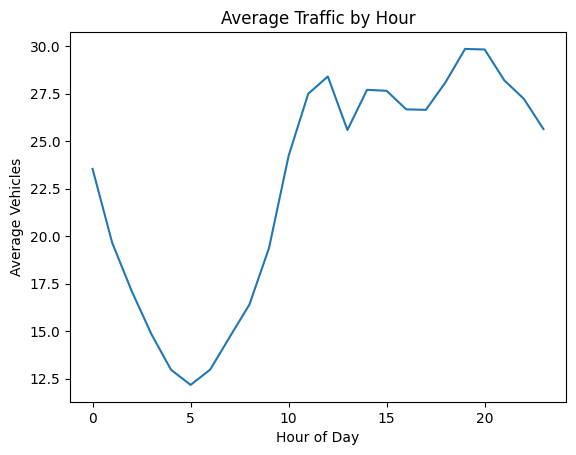

In [43]:
# 1) Hourly Traffic Line Chart (Peak Hour Visualization)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.lineplot(data=hourly_avg, x='Hour', y='Vehicles')
plt.title("Average Traffic by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Vehicles")
plt.show()

In [44]:
# Observations:-
# Traffic is lowest between 4 AM – 6 AM,
# increases from 7 AM onward,
# remains moderately high between 11 AM – 4 PM,
# is highest between 6 PM – 8 PM,
# and then gradually decreases after 9 PM.

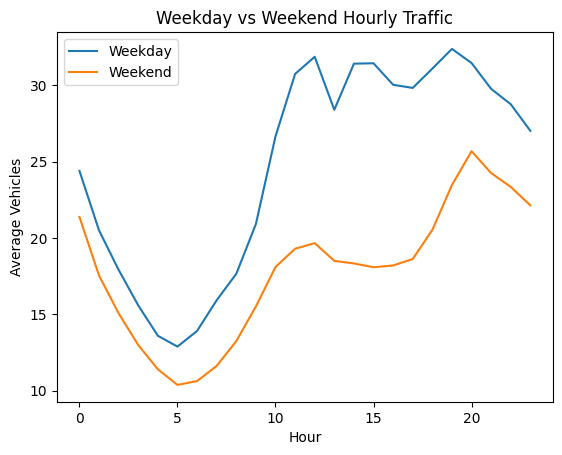

In [45]:
# 2) Weekday vs Weekend Hourly Comparison
plt.figure()
sns.lineplot(data=weekday_hourly, x='Hour', y='Vehicles', label='Weekday')
sns.lineplot(data=weekend_hourly, x='Hour', y='Vehicles', label='Weekend')

plt.title("Weekday vs Weekend Hourly Traffic")
plt.xlabel("Hour")
plt.ylabel("Average Vehicles")
plt.legend()
plt.show()

In [46]:
# Observations:-
# Shows weekday peak at 7 PM
# Weekend peak at 8 PM
# Weekday traffic clearly higher

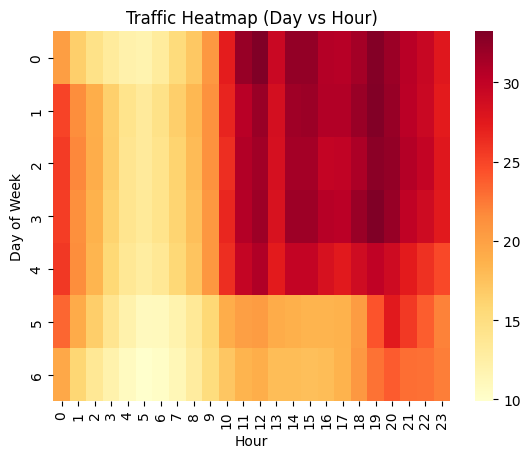

In [47]:
# 3) Heatmap (Hour vs Day of Week)
heatmap_data = df_hourly.pivot_table(
    values='Vehicles',
    index='DayOfWeek',
    columns='Hour',
    aggfunc='mean'
)

plt.figure()
sns.heatmap(heatmap_data, cmap="YlOrRd")
plt.title("Traffic Heatmap (Day vs Hour)")
plt.xlabel("Hour")
plt.ylabel("Day of Week")
plt.show()

In [48]:
# Observations:-
# Peak Traffic: 10 AM–7 PM, especially 11 AM–3 PM; higher on weekdays.
# Low Traffic: 0–6 AM; weekends lighter overall.
# Daily Pattern: Traffic rises from 6–10 AM, peaks midday, tapers after 5–6 PM.
# Weekday vs Weekend: Weekdays have higher peaks; weekends show moderate, consistent traffic.
# Trend: Diurnal pattern with morning ramp-up, midday peak, and evening taper.

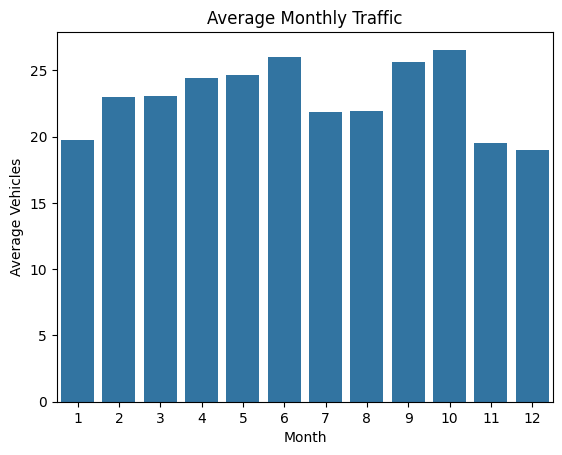

In [49]:
# Monthly Traffic Bar Chart
plt.figure()
sns.barplot(data=monthly_pattern, x='Month', y='Vehicles')

plt.title("Average Monthly Traffic")
plt.xlabel("Month")
plt.ylabel("Average Vehicles")
plt.show()

In [50]:
# There seems to be a seasonal variation, possibly related to holidays, weather, or local events.
# The traffic is relatively stable in the first half of the year, dips slightly in mid-year (July–August), 
# then peaks again in September–October before dropping at year-end.

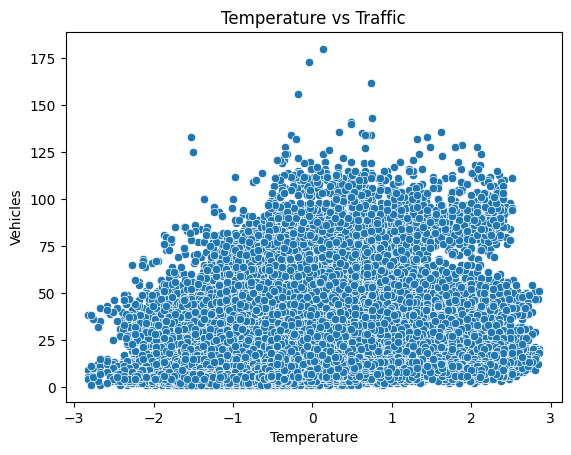

In [51]:
# Scatter Plot (Weather vs Traffic)
plt.figure()
sns.scatterplot(data=df_hourly, x='Temperature', y='Vehicles')

plt.title("Temperature vs Traffic")
plt.xlabel("Temperature")
plt.ylabel("Vehicles")
plt.show()

In [52]:
# The scatter plot shows no clear linear relationship between temperature and traffic. 
# Traffic (vehicles) varies widely across all temperature values, with most points clustered between 0–100 vehicles, 
# indicating that temperature alone doesn’t strongly affect traffic volume.

In [53]:
# Actionable Insights & Recommendations
# ️Optimize Signals During Peak Hours
# Adjust traffic signal timing between 6 PM – 8 PM to handle heavy evening congestion.

# Increase Traffic Monitoring on Weekdays
# Deploy traffic officers or smart monitoring systems during weekday evening rush hours.

# Encourage Staggered Office Timings
# Shifting work start/end times can reduce congestion around 7 PM peak.

# Promote Public Transport in High-Traffic Months
# During June and October, encourage public transport usage to reduce vehicle volume.

# Event-Based Traffic Planning
# Even though event impact is weak overall, monitor large events to avoid localized congestion.